In [1]:
from ucimlrepo import fetch_ucirepo 
import pandas as pd
import numpy as np

# Fetch dataset 
adult = fetch_ucirepo(id=2) 

# Data (as pandas dataframes) 
X = adult.data.features 
y = adult.data.targets 

# 1. First filter missing values from features
columns_to_check = ['workclass', 'native-country', 'occupation']
mask = (~X[columns_to_check].isin(['?']) & ~X[columns_to_check].isna()).all(axis=1)
filtered_X = X[mask].copy()
filtered_y = y[mask].copy()

# 2. Then clean the income column in the filtered data
filtered_y['income'] = filtered_y['income'].str.rstrip('.')

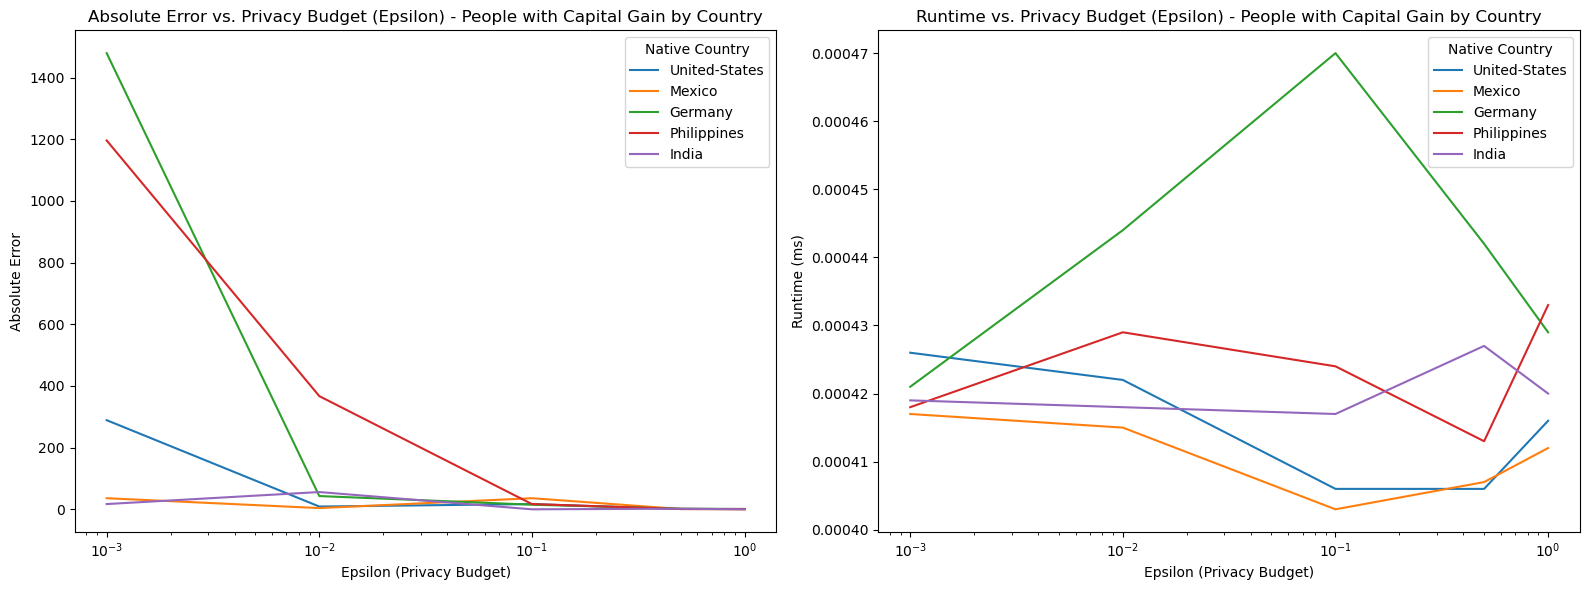

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time

# Create a combined DataFrame for easier analysis
combined_df = pd.concat([filtered_X, filtered_y], axis=1)

# Define privacy budgets
epsilon_values = [0.001, 0.01, 0.1, 0.5, 1]

# Laplace mechanism for differential privacy
def laplace_mechanism(count, epsilon, sensitivity=1.0):
    scale = sensitivity / epsilon
    noise = np.random.laplace(0, scale)
    return max(0, int(round(count + noise)))

# Measure runtime
def measure_runtime(func, count, epsilon, num_iterations=1000):
    start_time = time.time()
    for _ in range(num_iterations):
        func(count, epsilon)
    end_time = time.time()
    return ((end_time - start_time) / num_iterations) * 1000  # ms

# Filter for people with capital gain
capital_gain_df = combined_df[combined_df['capital-gain'] > 0]

# Find top 5 most common native countries among those with capital gain
top_countries = capital_gain_df['native-country'].value_counts().nlargest(5).index.tolist()

# Calculate results
results = []
np.random.seed(42)

for country in top_countries:
    # Count people from this country with capital gain
    true_count = len(capital_gain_df[capital_gain_df['native-country'] == country])
    
    for epsilon in epsilon_values:
        dp_count = laplace_mechanism(true_count, epsilon)
        runtime = measure_runtime(laplace_mechanism, true_count, epsilon)
        abs_error = abs(true_count - dp_count)
        
        results.append({
            'Native Country': country,
            'Epsilon': epsilon,
            'True Count': true_count,
            'Absolute Error': abs_error,
            'Runtime (ms)': round(runtime, 6)
        })

results_df = pd.DataFrame(results)

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Absolute Error - Line plot with markers
sns.lineplot(x='Epsilon', y='Absolute Error', hue='Native Country', 
             markers=True, dashes=False, data=results_df, ax=ax1)
ax1.set_title('Absolute Error vs. Privacy Budget (Epsilon) - People with Capital Gain by Country')
ax1.set_xlabel('Epsilon (Privacy Budget)')
ax1.set_ylabel('Absolute Error')
ax1.set_xscale('log')  # Log scale makes the epsilon values more evenly spaced

# Plot 2: Runtime - Line plot with markers
sns.lineplot(x='Epsilon', y='Runtime (ms)', hue='Native Country', 
             markers=True, dashes=False, data=results_df, ax=ax2)
ax2.set_title('Runtime vs. Privacy Budget (Epsilon) - People with Capital Gain by Country')
ax2.set_xlabel('Epsilon (Privacy Budget)')
ax2.set_ylabel('Runtime (ms)')
ax2.set_xscale('log')

plt.tight_layout()
plt.show()

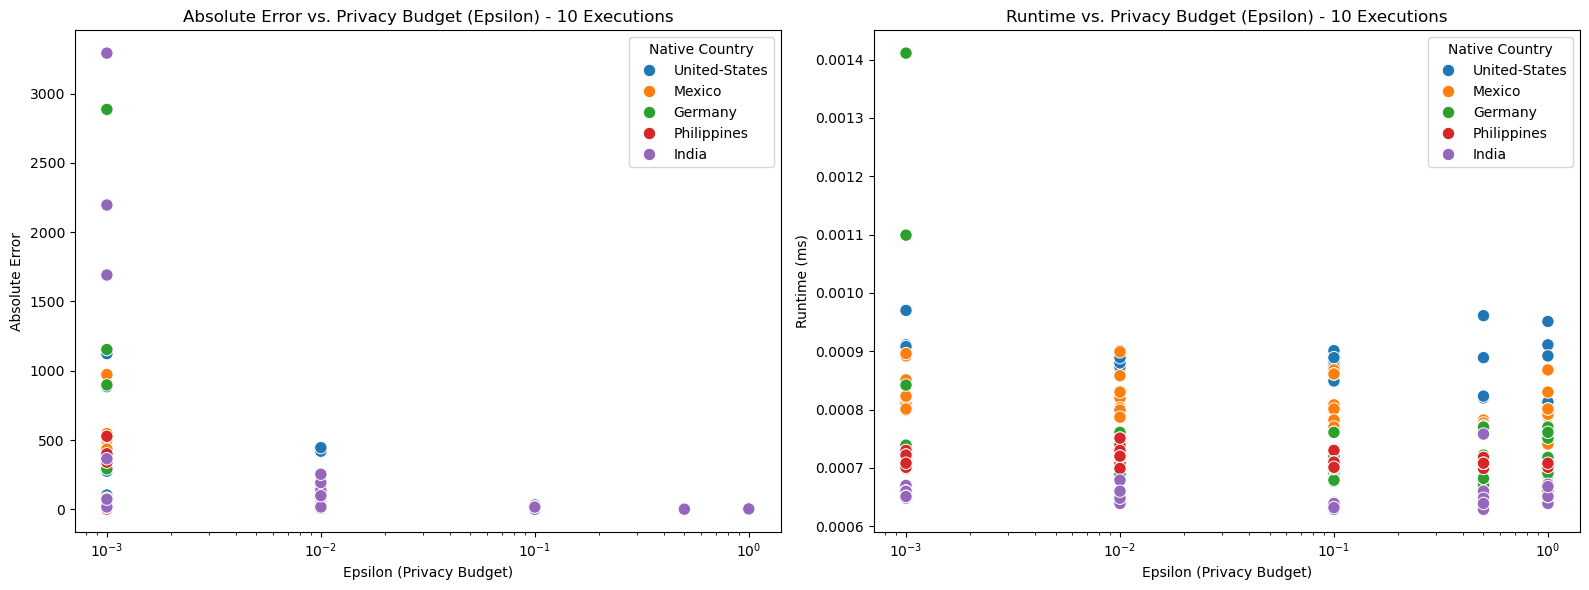

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time

# Laplace mechanism for differential privacy
def laplace_mechanism(count, epsilon, sensitivity=1.0):
    scale = sensitivity / epsilon
    noise = np.random.laplace(0, scale)
    return max(0, int(round(count + noise)))

# Measure runtime
def measure_runtime(func, count, epsilon, num_iterations=100):
    start_time = time.time()
    for _ in range(num_iterations):
        func(count, epsilon)
    end_time = time.time()
    return ((end_time - start_time) / num_iterations) * 1000  # ms

# Define privacy budgets and number of executions
epsilon_values = [0.001, 0.01, 0.1, 0.5, 1]
num_executions = 10

# Filter for people with capital gain
capital_gain_df = combined_df[combined_df['capital-gain'] > 0]

# Find top 5 most common native countries among those with capital gain
top_countries = capital_gain_df['native-country'].value_counts().nlargest(5).index.tolist()

# Calculate results for multiple executions
results = []
np.random.seed(42)

for country in top_countries:
    # Count people from this country with capital gain
    true_count = len(capital_gain_df[capital_gain_df['native-country'] == country])
    
    for epsilon in epsilon_values:
        # Run 10 independent executions
        for execution in range(num_executions):
            dp_count = laplace_mechanism(true_count, epsilon)
            runtime = measure_runtime(laplace_mechanism, true_count, epsilon)
            abs_error = abs(true_count - dp_count)
            
            results.append({
                'Native Country': country,
                'Epsilon': epsilon,
                'True Count': true_count,
                'DP Count': dp_count,
                'Absolute Error': abs_error,
                'Runtime (ms)': round(runtime, 6),
                'Execution': execution + 1
            })

results_df = pd.DataFrame(results)

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Absolute Error vs. Epsilon - Scatter plot
sns.scatterplot(x='Epsilon', y='Absolute Error', hue='Native Country', data=results_df, s=80, ax=ax1)
ax1.set_title('Absolute Error vs. Privacy Budget (Epsilon) - 10 Executions')
ax1.set_xlabel('Epsilon (Privacy Budget)')
ax1.set_ylabel('Absolute Error')
ax1.set_xscale('log')  # Log scale for epsilon values

# Plot 2: Runtime vs. Epsilon - Scatter plot
sns.scatterplot(x='Epsilon', y='Runtime (ms)', hue='Native Country', data=results_df, s=80, ax=ax2)
ax2.set_title('Runtime vs. Privacy Budget (Epsilon) - 10 Executions')
ax2.set_xlabel('Epsilon (Privacy Budget)')
ax2.set_ylabel('Runtime (ms)')
ax2.set_xscale('log')  # Log scale for epsilon values

plt.tight_layout()
plt.show()

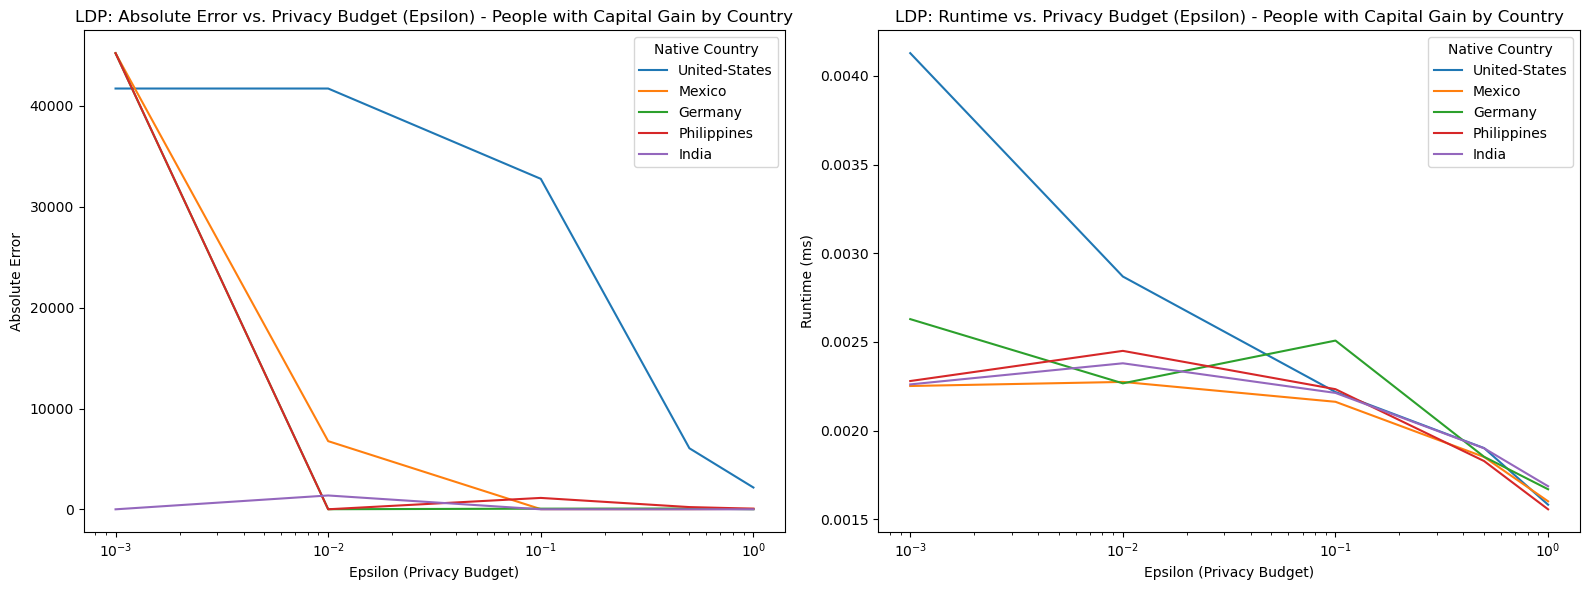

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time

# Create a combined DataFrame for easier analysis
combined_df = pd.concat([filtered_X, filtered_y], axis=1)

# Define epsilon values for Local Differential Privacy
epsilon_values_ldp = [0.001, 0.01, 0.1, 0.5, 1.0]

# Filter for people with capital gain
capital_gain_df = combined_df[combined_df['capital-gain'] > 0]

# Find top 5 most common native countries among those with capital gain
top_countries = capital_gain_df['native-country'].value_counts().nlargest(5).index.tolist()

# Randomized Response mechanism for Local Differential Privacy for complex query
def randomized_response_complex(country, has_gain, target_country, epsilon):
    """
    Implements randomized response for Local Differential Privacy on a complex query.
    Checks if (country == target_country AND has_gain), and privatizes this binary information.
    
    Args:
        country: Person's native country
        has_gain: Whether person has capital gain
        target_country: The country we're checking for
        epsilon: Privacy parameter
    
    Returns:
        Privatized boolean indicating if person is from target country with capital gain
    """
    # Calculate probability of keeping true value
    p = np.exp(epsilon) / (1 + np.exp(epsilon))
    
    # The true binary outcome - is person from target country with capital gain?
    true_outcome = (country == target_country and has_gain)
    
    # With probability p, keep the true outcome
    # With probability 1-p, flip a coin
    if np.random.random() < p:
        return true_outcome
    else:
        return np.random.choice([True, False])

# Function to measure runtime
def measure_ldp_runtime(func, country, has_gain, target_country, epsilon, num_iterations=1000):
    start_time = time.time()
    for _ in range(num_iterations):
        func(country, has_gain, target_country, epsilon)
    end_time = time.time()
    return ((end_time - start_time) / num_iterations) * 1000  # ms

# Calculate results for LDP
ldp_results = []
np.random.seed(42)  # Set seed for reproducibility

total_people = len(combined_df)

for country in top_countries:
    for epsilon in epsilon_values_ldp:
        # Measure average runtime
        runtime = measure_ldp_runtime(randomized_response_complex, 
                                     "United-States", True, "United-States", epsilon)
        
        # Apply randomized response to each individual
        privatized_matches = []
        for _, row in combined_df.iterrows():
            has_gain = row['capital-gain'] > 0
            privatized_match = randomized_response_complex(
                row['native-country'], has_gain, country, epsilon)
            privatized_matches.append(privatized_match)
        
        # Get true count of people from this country with capital gain
        true_count = len(combined_df[(combined_df['native-country'] == country) & 
                                    (combined_df['capital-gain'] > 0)])
        
        # Count of privatized responses that are True
        privatized_count = privatized_matches.count(True)
        
        # Calculate corrected estimate
        p = np.exp(epsilon) / (1 + np.exp(epsilon))
        corrected_estimate = (privatized_count - total_people*(1-p)/2) / (2*p - 1)
        corrected_estimate = int(round(corrected_estimate))
        
        # Ensure the corrected estimate is non-negative and doesn't exceed total
        corrected_estimate = max(0, min(corrected_estimate, total_people))
        
        # Calculate error metrics
        abs_error = abs(true_count - corrected_estimate)
        
        ldp_results.append({
            'Native Country': country,
            'Epsilon': epsilon,
            'True Count': true_count,
            'LDP Count': privatized_count,
            'Corrected Estimate': corrected_estimate,
            'Absolute Error': abs_error,
            'Runtime (ms)': round(runtime, 6)
        })

ldp_results_df = pd.DataFrame(ldp_results)

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Absolute Error - Line plot with markers
sns.lineplot(x='Epsilon', y='Absolute Error', hue='Native Country', 
             markers=True, dashes=False, data=ldp_results_df, ax=ax1)
ax1.set_title('LDP: Absolute Error vs. Privacy Budget (Epsilon) - People with Capital Gain by Country')
ax1.set_xlabel('Epsilon (Privacy Budget)')
ax1.set_ylabel('Absolute Error')
ax1.set_xscale('log')  # Log scale makes the epsilon values more evenly spaced

# Plot 2: Runtime - Line plot with markers
sns.lineplot(x='Epsilon', y='Runtime (ms)', hue='Native Country', 
             markers=True, dashes=False, data=ldp_results_df, ax=ax2)
ax2.set_title('LDP: Runtime vs. Privacy Budget (Epsilon) - People with Capital Gain by Country')
ax2.set_xlabel('Epsilon (Privacy Budget)')
ax2.set_ylabel('Runtime (ms)')
ax2.set_xscale('log')

plt.tight_layout()
plt.show()

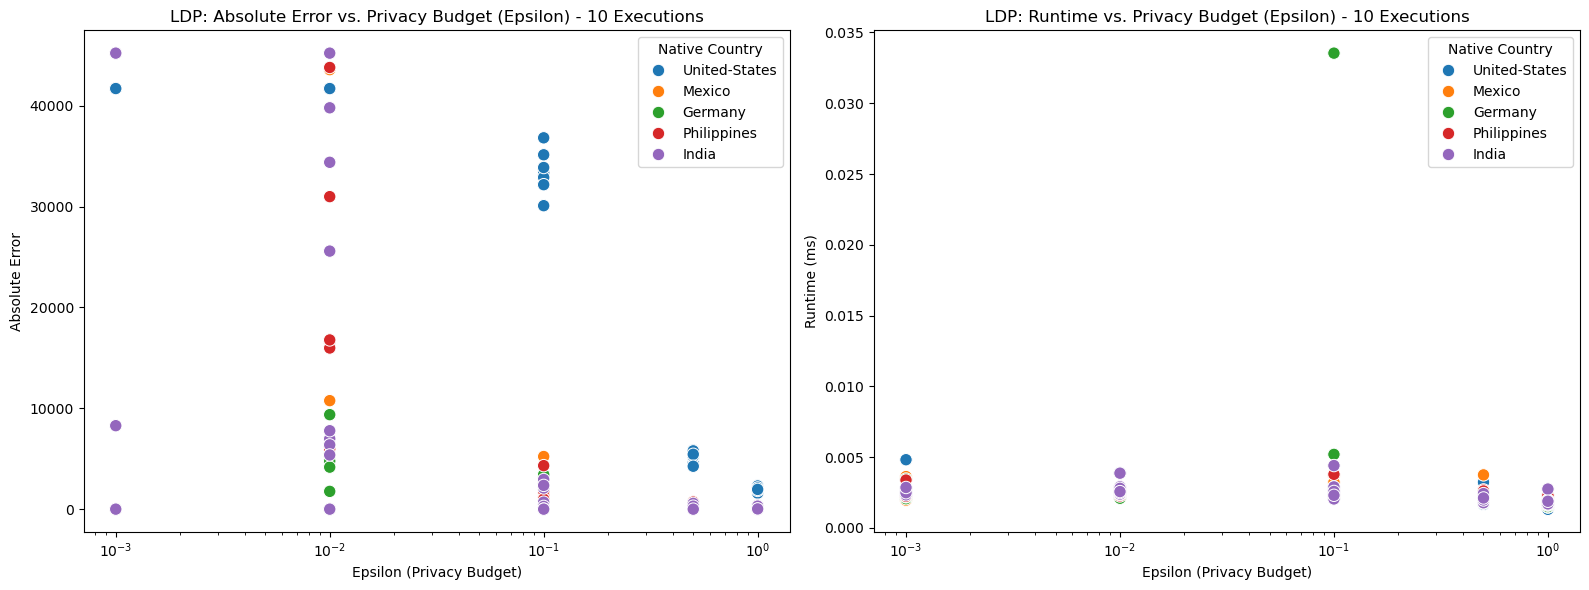

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time

# Define epsilon values for Local Differential Privacy
epsilon_values = [0.001, 0.01, 0.1, 0.5, 1.0]
num_executions = 10

# Randomized Response mechanism for Local Differential Privacy
def randomized_response_complex(country, has_gain, target_country, epsilon):
    # Calculate probability of keeping true value
    p = np.exp(epsilon) / (1 + np.exp(epsilon))
    
    # The true binary outcome - is person from target country with capital gain?
    true_outcome = (country == target_country and has_gain)
    
    # With probability p, keep the true outcome
    # With probability 1-p, flip a coin
    if np.random.random() < p:
        return true_outcome
    else:
        return np.random.choice([True, False])

# Function to measure runtime
def measure_ldp_runtime(func, country, has_gain, target_country, epsilon, num_iterations=100):
    start_time = time.time()
    for _ in range(num_iterations):
        func(country, has_gain, target_country, epsilon)
    end_time = time.time()
    return ((end_time - start_time) / num_iterations) * 1000  # ms

# Filter for people with capital gain
capital_gain_df = combined_df[combined_df['capital-gain'] > 0]

# Find top 5 most common native countries among those with capital gain
top_countries = capital_gain_df['native-country'].value_counts().nlargest(5).index.tolist()

# Calculate results for LDP with multiple executions
ldp_results = []
np.random.seed(42)  # Set seed for reproducibility

total_people = len(combined_df)

for country in top_countries:
    # Get true count of people from this country with capital gain
    true_count = len(combined_df[(combined_df['native-country'] == country) & 
                               (combined_df['capital-gain'] > 0)])
    
    for epsilon in epsilon_values:
        # Run 10 independent executions
        for execution in range(num_executions):
            # Measure average runtime
            runtime = measure_ldp_runtime(randomized_response_complex, 
                                        "United-States", True, "United-States", epsilon)
            
            # Apply randomized response to each individual
            privatized_matches = []
            for _, row in combined_df.iterrows():
                has_gain = row['capital-gain'] > 0
                privatized_match = randomized_response_complex(
                    row['native-country'], has_gain, country, epsilon)
                privatized_matches.append(privatized_match)
            
            # Count of privatized responses that are True
            privatized_count = privatized_matches.count(True)
            
            # Calculate corrected estimate
            p = np.exp(epsilon) / (1 + np.exp(epsilon))
            corrected_estimate = (privatized_count - total_people*(1-p)/2) / (2*p - 1)
            corrected_estimate = int(round(corrected_estimate))
            
            # Ensure the corrected estimate is non-negative and doesn't exceed total
            corrected_estimate = max(0, min(corrected_estimate, total_people))
            
            # Calculate error metrics
            abs_error = abs(true_count - corrected_estimate)
            
            ldp_results.append({
                'Native Country': country,
                'Epsilon': epsilon,
                'True Count': true_count,
                'Corrected Estimate': corrected_estimate,
                'Absolute Error': abs_error,
                'Runtime (ms)': round(runtime, 6),
                'Execution': execution + 1
            })

ldp_results_df = pd.DataFrame(ldp_results)

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Absolute Error vs. Epsilon - Scatter plot
sns.scatterplot(x='Epsilon', y='Absolute Error', hue='Native Country', 
                data=ldp_results_df, s=80, ax=ax1)
ax1.set_title('LDP: Absolute Error vs. Privacy Budget (Epsilon) - 10 Executions')
ax1.set_xlabel('Epsilon (Privacy Budget)')
ax1.set_ylabel('Absolute Error')
ax1.set_xscale('log')  # Log scale for epsilon values

# Plot 2: Runtime vs. Epsilon - Scatter plot
sns.scatterplot(x='Epsilon', y='Runtime (ms)', hue='Native Country', 
                data=ldp_results_df, s=80, ax=ax2)
ax2.set_title('LDP: Runtime vs. Privacy Budget (Epsilon) - 10 Executions')
ax2.set_xlabel('Epsilon (Privacy Budget)')
ax2.set_ylabel('Runtime (ms)')
ax2.set_xscale('log')  # Log scale for epsilon values

plt.tight_layout()
plt.show()